In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_2d, plot_2d_distribution, kl_estimate_with_mc, compute_variational_posterior
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

# Problem 1

The KL between q and p is 50.000 nats.


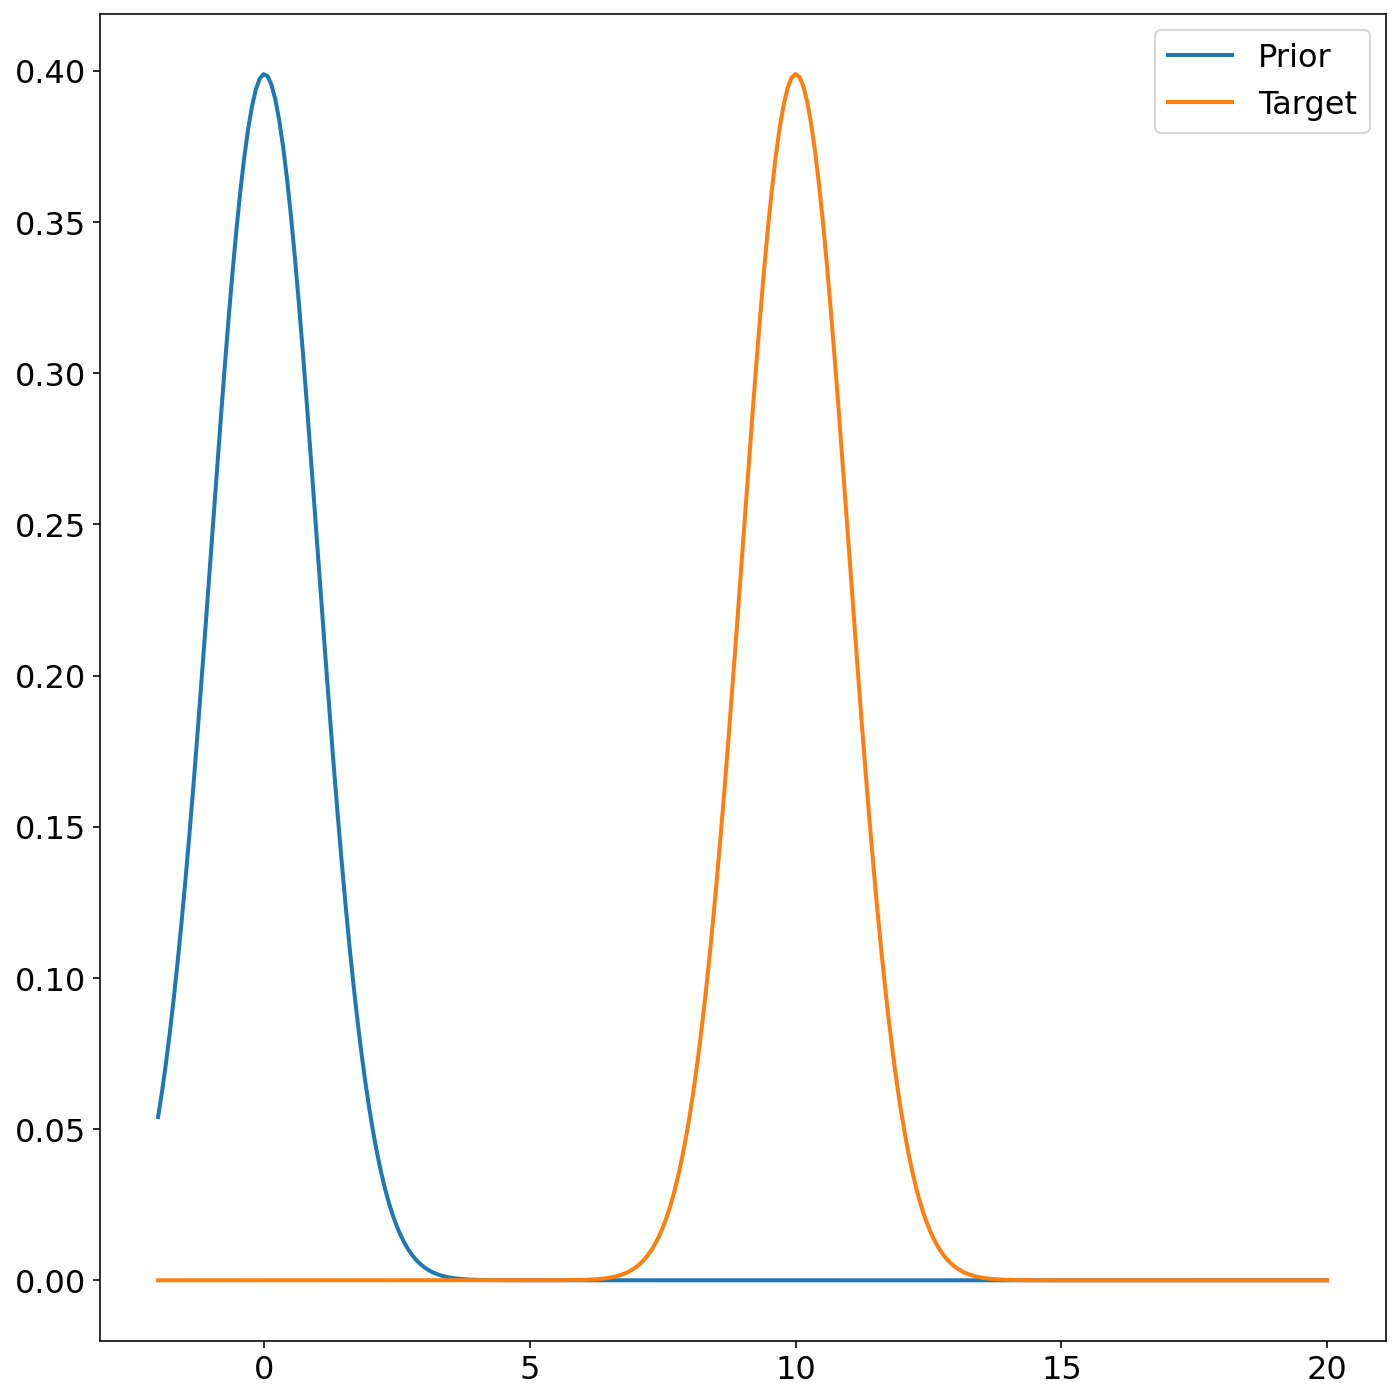

In [8]:
torch.manual_seed(100)
q_loc = [10.]
q_var = 1.

p_loc = [0.]
p_var = 1.

q = dist.MultivariateNormal(loc=torch.tensor(q_loc), covariance_matrix = q_var * torch.eye(1))
p = dist.MultivariateNormal(loc=torch.tensor(p_loc), covariance_matrix = p_var * torch.eye(1))

z_sample = q.mean

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================
xs = torch.linspace(-2., 20., 300).reshape(-1, 1)

f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(xs, torch.exp(p.log_prob(xs)))
ax.plot(xs, torch.exp(q.log_prob(xs)))
ax.legend(['Prior', 'Target'])
f.tight_layout()


In [9]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [18]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(q,
                         initial_seed,
                         coding_sampler,
                         selection_sampler,
                         auxiliary_posterior,
                         omega,
                         n_samples_from_target=1,
                         beamwidth=beamwidth,
                         epsilon=epsilon,
                         prior_var=p_var)


n_trajectories = 1024
n_auxiliaries = dummy_encoder.n_auxiliary
print(n_auxiliaries)
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, total_kl, n_trajectories, p_var, lr=1e-4)
emp_opt.pre_softmax_aux_vars = logits
aux_vars = emp_opt.run_optimiser(epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

10


The mean loss is 5.07506. The mean KL is: 5.40370: 100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]


In [19]:
logits = emp_opt.pre_softmax_aux_vars

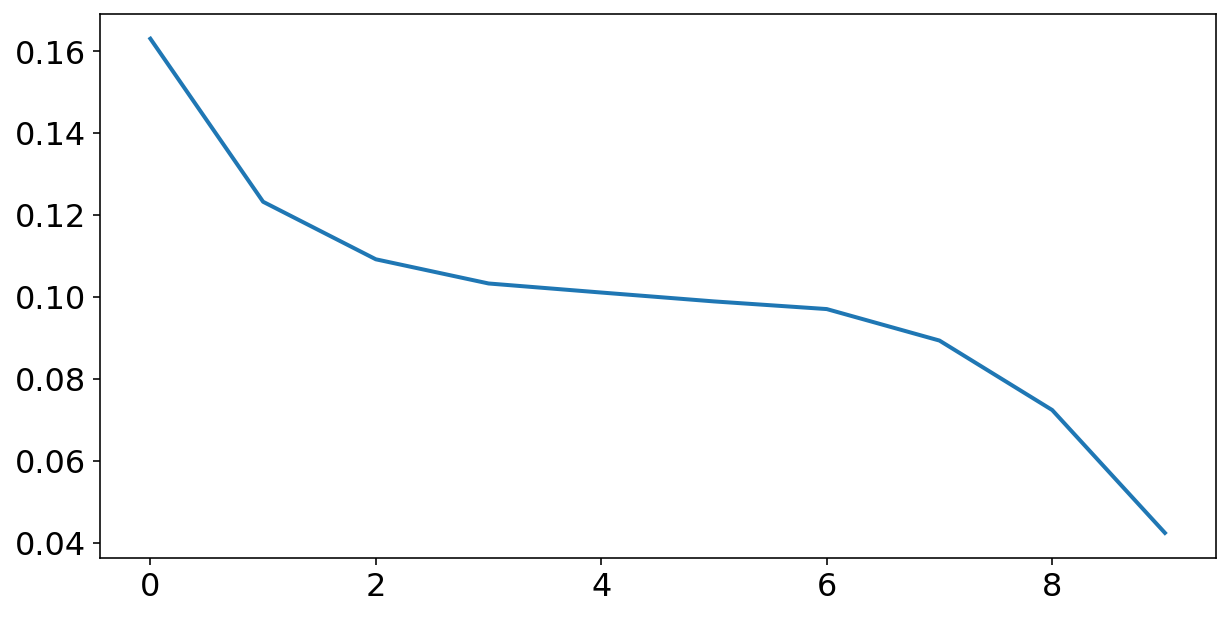

In [21]:
f, ax = plt.subplots(1, figsize=(10,5))
ax.plot(torch.softmax(logits.detach(), dim=0).detach())

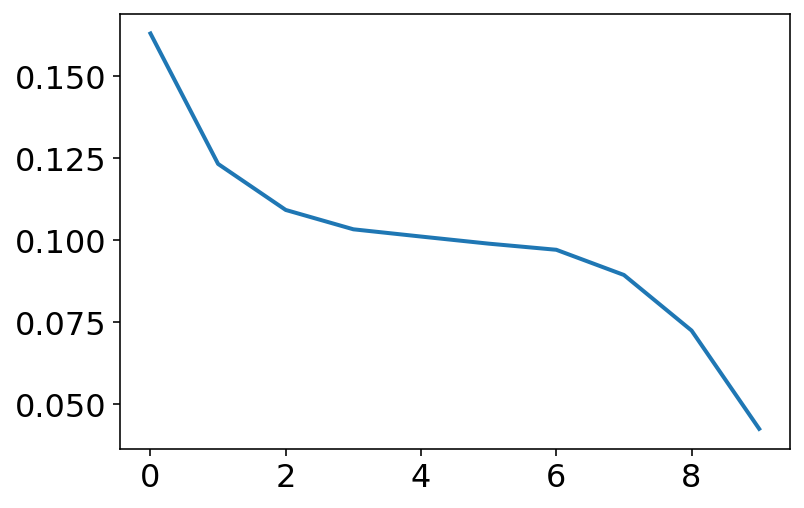

In [23]:
plt.plot(aux_vars)